In [17]:
# Refactored Calibration and Simulation Script for Gipps Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def kmh_to_ms(speed_kmh):
    return speed_kmh * (1000 / 3600)

# --- Gipps Model Implementation ---
def gipps_model(params, time, lead_speed, initial_spacing, initial_speed):
    V, a_max, b_follower, b_leader, s0, tau = params
    spacing = [initial_spacing]
    speed = [initial_speed]

    for t in range(1, len(time)):
        dt = time[t] - time[t - 1]
        v = speed[-1]
        s = spacing[-1]
        v_lead = lead_speed[t - 1]

        # Acceleration-based speed update
        v_desired = v + 2.5 * a_max * tau * (1 - v / V) * np.sqrt(0.025 + v / V)

        # Safety-based speed update
        s_safe = s - s0
        try:
#             braking_term = b_follower * tau + np.sqrt(
#                 max(0, b_follower**2 * tau**2 - b_follower * (2 * s_safe - v * tau - (v_lead**2) / b_leader))
#             )
            inner = b_follower**2 * tau**2 - b_follower * (2 * s_safe - v * tau - (v_lead**2) / b_leader)
            braking_term = b_follower * tau + np.sqrt(max(0, inner))
        except ValueError:
            braking_term = 0  # fallback to prevent crash

        v_next = max(0, min(v_desired, braking_term))
#         s_next = max(0, s + (v_lead - v) * dt)
        s_next = max(0.1, s + (v_lead - v) * dt)


        speed.append(v_next)
        spacing.append(s_next)

    return np.array(spacing), np.array(speed)

# --- Objective Function for Gipps ---
def objective_gipps(params, time, lead_speed, experimental_spacing, initial_spacing, initial_speed):
    simulated_spacing, _ = gipps_model(params, time, lead_speed, initial_spacing, initial_speed)
    rmse = np.sqrt(np.mean((simulated_spacing - experimental_spacing) ** 2))
    return rmse

# --- Calibration Function ---
def calibrate_gipps(df, subset_duration=200, dt=0.02):
    subset_length = int(subset_duration / dt)
    num_subsets = 6
    subsets = [df.iloc[i * subset_length:(i + 1) * subset_length] for i in range(num_subsets)]

    best_rmse = np.inf
    best_params = None

    for i, subset in enumerate(subsets):
        print(f"\n--- Calibrating on subset {i + 1}/{num_subsets} ---")

        time = subset['Time'].values
        lead_speed = subset['Speed Leader'].values
        spacing = subset['Spacing'].values
        follower_speed = subset['Speed Follower'].values

        initial_spacing = spacing[0]
        initial_speed = follower_speed[0]

        # [V, a_max, b_follower, b_leader, s0, tau]
#         initial_params = [25.0, 1.0, 1.5, 1.5, 2.0, 1.0]
        initial_params = [20.0, 0.8, 1.0, 1.0, 2.0, 1.0]

        bounds = [(10, 40), (0.5, 3.0), (0.5, 3.0), (0.5, 3.0), (0.5, 5.0), (0.5, 2.0)]

        result = minimize(objective_gipps, initial_params,
                          args=(time, lead_speed, spacing, initial_spacing, initial_speed),
                          bounds=bounds, method='L-BFGS-B')

        rmse = objective_gipps(result.x, time, lead_speed, spacing, initial_spacing, initial_speed)
        print(f"Subset {i + 1} RMSE: {rmse:.4f}")
        print(f"Params: {result.x}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = result.x

    print("\n--- Best Calibration Results ---")
    print(f"Best Params: {best_params}")
    print(f"Best RMSE: {best_rmse:.4f}")
    return best_params

# --- Evaluation and Plotting ---
def simulate_and_plot_gipps(df, best_params, model_name="Gipps", report_path="./", limit=None):
    time = df['Time'].values
    lead_speed = df['Speed Leader'].values
    follower_speed = df['Speed Follower'].values
    spacing = df['Spacing'].values

    simulated_spacing, simulated_speed = gipps_model(best_params, time, lead_speed, spacing[0], follower_speed[0])
    rmse = np.sqrt(np.mean((simulated_spacing - spacing) ** 2))
    print(f"\nFull Dataset RMSE: {rmse:.4f}")

    if limit is not None:
        start, end = limit
        mask = (time >= start) & (time <= end)
        time = time[mask]
        spacing = spacing[mask]
        simulated_spacing = simulated_spacing[mask]
        follower_speed = follower_speed[mask]
        simulated_speed = simulated_speed[mask]
        lead_speed = lead_speed[mask]

    plt.figure(figsize=(12, 6))
    plt.plot(time, spacing, label='Experimental Spacing', color='blue')
    plt.plot(time, simulated_spacing, label='Simulated Spacing', color='red', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Spacing (m)')
    plt.title(f'Spacing Comparison - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_spacing.png")
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(time, follower_speed, label='Experimental Follower Speed', color='blue')
    plt.plot(time, simulated_speed, label='Simulated Follower Speed', color='red', linestyle='--')
    plt.plot(time, lead_speed, label='Leader Speed', color='green', linestyle=':')
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Speed Comparison - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_speed.png")
    plt.show()


In [18]:
def test_and_viz_full_dataset(df, best_params,model_name,report_path, limit=None):
    # Extract relevant columns
    time = np.arange(0, len(df) * 0.02, 0.02)  # Assuming time increments by 0.02 seconds
    #     time = df['Time'].values
    lead_speed = df['Speed Leader'].values
    follow_speed = df['Speed Follower'].values
    experimental_spacing = df['Spacing'].values  # Assuming this is the spacing

    # Test the best model on the entire dataset
    # simulated_spacing_full, simulated_speed_full = idm_model(best_params, time, lead_speed, experimental_spacing[0],
    #                                                          follow_speed[0])
    simulated_spacing_full, simulated_speed_full = gipps_model(best_params, time, lead_speed, experimental_spacing[0],
                                                             follow_speed[0])
    rmse_full = np.sqrt(np.mean((simulated_spacing_full - experimental_spacing) ** 2))
    print("-----------------------------------------------------------------------------")
    print(f"Full dataset RMSE: {rmse_full:.4f}")

    # Apply the limit to the data
    if limit is not None:
        start, end = limit
        mask = (time >= start) & (time <= end)
        time = time[mask]
        experimental_spacing = experimental_spacing[mask]
        simulated_spacing_full = simulated_spacing_full[mask]
        follow_speed = follow_speed[mask]
        simulated_speed_full = simulated_speed_full[mask]
        lead_speed = lead_speed[mask]

    # Visualize the results
    import matplotlib.pyplot as plt

    # Plot simulated vs experimental spacing
    plt.figure(figsize=(12, 6))
    plt.plot(time, experimental_spacing, label='Experimental Spacing', color='blue', linestyle='-', linewidth=1)
    plt.plot(time, simulated_spacing_full, label='Simulated Spacing', color='red', linestyle='-', linewidth=1)
    plt.xlabel('Time (s)')
    plt.ylabel('Spacing (m)')
    plt.title(f'Simulated vs Experimental Spacing of {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_spacing.png")
    plt.show()

    # Plot simulated vs experimental speed (including leader speed)
    plt.figure(figsize=(12, 6))
    plt.plot(time, follow_speed, label='Experimental Follower Speed', color='blue', linestyle='-', linewidth=1)
    plt.plot(time, simulated_speed_full, label='Simulated Follower Speed', color='red', linestyle='-', linewidth=1)
    plt.plot(time, lead_speed, label='Leader Speed', color='green', linestyle='-', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Simulated vs Experimental Speed of {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{report_path}{model_name}_speed.png")
    plt.show()

In [19]:

df = pd.read_csv("../data/combined_data.csv")
df['Speed Follower'] = kmh_to_ms(df['Speed Follower'])
df['Speed Leader'] = kmh_to_ms(df['Speed Leader'])

medium_gap_df = df[df['gap_setting'] == 'Medium']
best_params = calibrate_gipps(medium_gap_df)



--- Calibrating on subset 1/6 ---
Subset 1 RMSE: 19.2967
Params: [15.32562234  3.          3.          0.5         5.          2.        ]

--- Calibrating on subset 2/6 ---
Subset 2 RMSE: 20.5195
Params: [19.71938357  0.79910524  0.9804231   1.05073017  2.00827962  1.01295528]

--- Calibrating on subset 3/6 ---
Subset 3 RMSE: 25.4345
Params: [19.48617784  0.5         3.          0.5         2.10491972  0.5       ]

--- Calibrating on subset 4/6 ---
Subset 4 RMSE: 31.0978
Params: [24.15960086  2.99999162  3.          0.5         5.          1.99999281]

--- Calibrating on subset 5/6 ---
Subset 5 RMSE: 28.6109
Params: [24.07107283  1.33695192  1.38065856  1.18329569  2.25326901  1.28660545]

--- Calibrating on subset 6/6 ---
Subset 6 RMSE: 20.7360
Params: [24.14045032  1.23507063  1.38513705  1.18014897  2.05107313  1.11491861]

--- Best Calibration Results ---
Best Params: [15.32562234  3.          3.          0.5         5.          2.        ]
Best RMSE: 19.2967


In [21]:
# simulate_and_plot_gipps(medium_gap_df, best_params, model_name="Gipps", report_path="../REPORTS/Gipps/", limit=(0, 170))

-----------------------------------------------------------------------------
Full dataset RMSE: 19109.1641


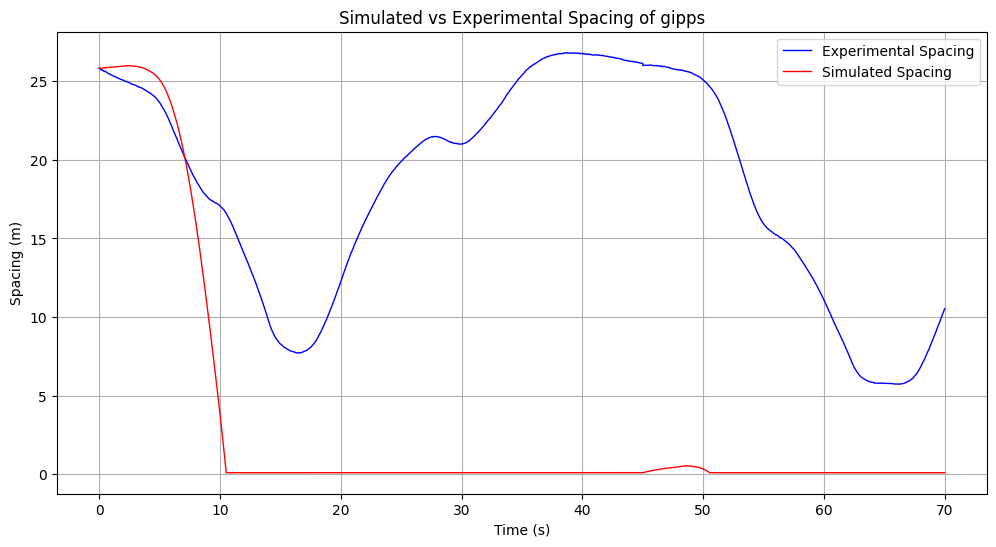

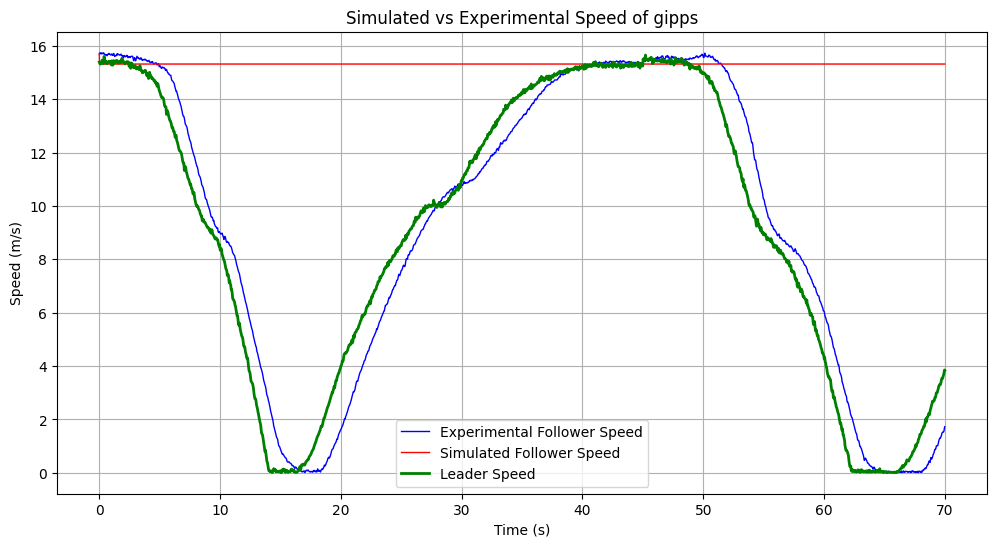

In [22]:
test_and_viz_full_dataset(medium_gap_df, best_params, model_name="gipps", report_path="../REPORTS/Gipps/", limit=(0, 70))